# <의사 결정 트리 모델에 XAI 적용>
# 실습 1: 타이타닉 생존자 예측

---



## 0. 데이터 구성
- PassengerID: 탑승객 고유 아이디
- Survived: 탑승객 생존 유무 (0: 사망, 1: 생존)
- Pclass: 객실의 등급
- Name: 이름
- Sex: 성별
- Age: 나이
- SibSp: 함께 탑승한 형제자매, 아내, 남편의 수
- Parch: 함께 탑승한 부모, 자식의 수
- Ticket: 티켓 번호
- Fare: 티켓의 요금
- Cabin: 객실번호
- Embarked: 배에 탑승한 항구 이름(C = Cherbourn, Q = Queenstown, S = Southampton)

In [ ]:
# 주피터 노트북 경고 메시지 삭제
import warnings
warnings.filterwarnings("ignore")

## 1. 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 주피터 노트북에서 그래프를 인라인으로 표시하도록 설정
%matplotlib inline

# 데이터 로딩
titanic_df = pd.read_csv('./titanic.csv')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
titanic_df.isnull().sum() # 결측치 데이터 개수 확인

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
# 데이터 전처리 (결측치 처리)
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True) # 객실번호: 'N'으로 결측치 채움
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum()) # 전처리 후 남은 결측치 개수 확인

데이터 세트 Null 값 개수  0


- `fillna()`:  DataFrame에서 결측값을 원하는 값으로 변경하는 메서드. inplace는 원본을 변경할지 여부 (True면 원본 변경)

## 2. EDA (탐색적 데이터 분석)

<Axes: xlabel='Sex', ylabel='Survived'>

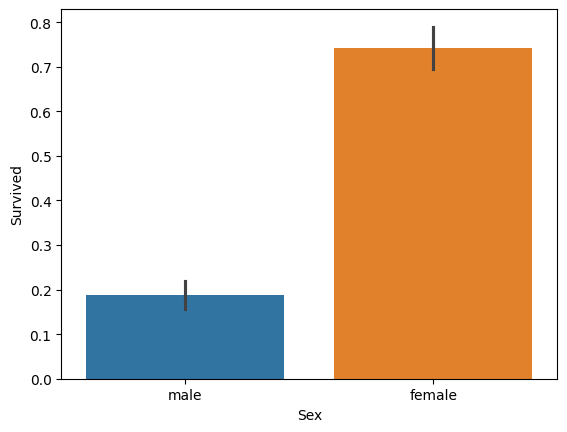

In [ ]:
# 성별에 따른 생존자 분포 확인
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()
sns.barplot(x='Sex', y='Survived', data=titanic_df, hue='Sex') # hue: 성별에 따라 색상 구분

- 'Sex'와 'Survived' 컬럼을 기준으로 데이터를 그룹화한 다음, 각 그룹 내에서 'Survived' 컬럼의 개수를 세어 준다

<Axes: xlabel='Pclass', ylabel='Survived'>

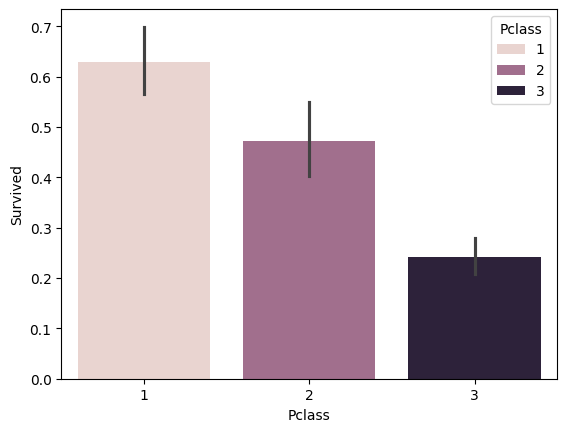

In [ ]:
# 객실 등급에 따른 생존자 분포 확인
titanic_df.groupby(['Pclass', 'Survived'])['Survived'].count()
sns.barplot(x='Pclass', y='Survived', hue='Pclass', data=titanic_df)

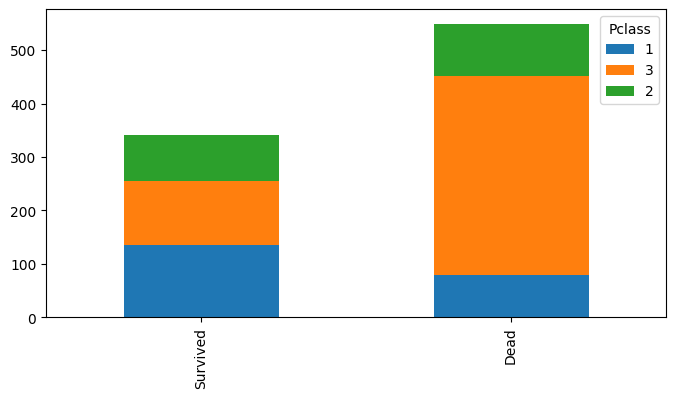

In [ ]:
def bar_chart(feature):
  survived = titanic_df[titanic_df['Survived']==1][feature].value_counts() # 생존한 승객 수 확인
  dead = titanic_df[titanic_df['Survived']==0][feature].value_counts() # 사망한 승객 수 확인
  df = pd.DataFrame([survived, dead])
  df.index = ['Survived', 'Dead']
  df.plot(kind='bar', stacked=True, figsize=(8,4))

bar_chart('Pclass')


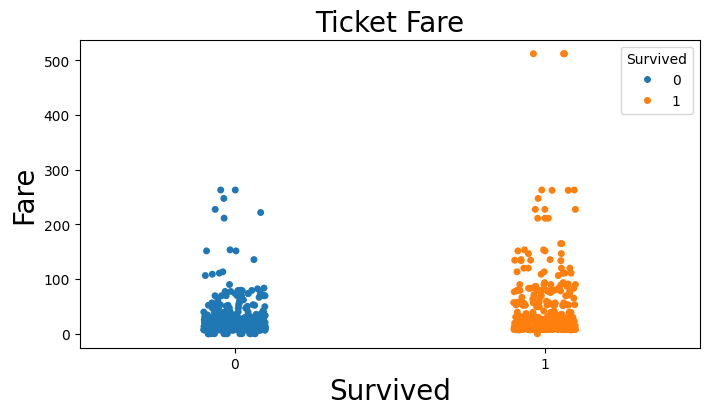

In [ ]:
# 티켓 요금에 따른 생존자 분포
plt.figure(figsize=(8,4))
plt.title('Ticket Fare', fontsize = 20)
sns.stripplot(x='Survived', y='Fare', data=titanic_df, hue='Survived')
plt.xlabel('Survived', fontsize=20)
plt.ylabel('Fare', fontsize=20)

plt.show()

In [ ]:
# 성별 데이터 다시 그룹화
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

# 나이에 따라 구분값을 반환하는 함수
def get_category(age):
  cat = ''
  if age <= -1: cat = 'Unknown'
  elif age <= 5: cat = 'Baby'
  elif age <= 12: cat = 'Child'
  elif age <= 18: cat = 'Teenager'
  elif age <= 25: cat = 'Student'
  elif age <= 35: cat = 'Young Adult'
  elif age <= 60: cat = 'Adult'
  else: cat = 'Eldery'

  return cat

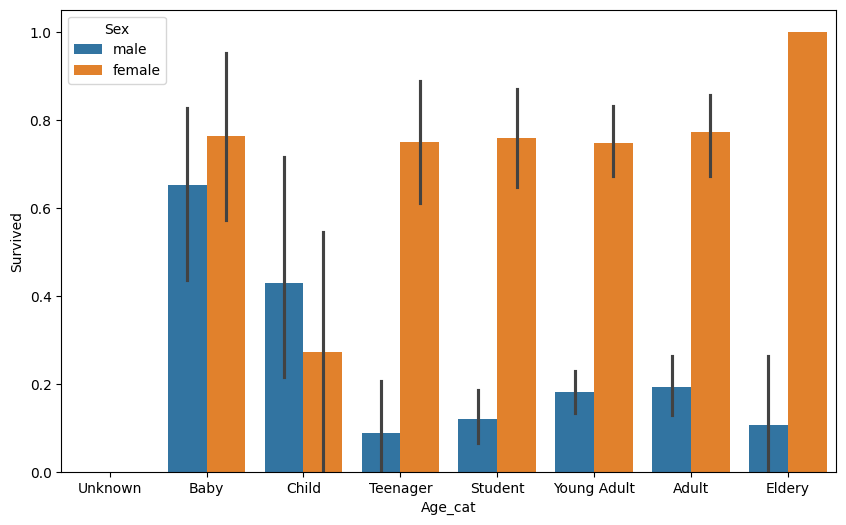

In [ ]:
plt.figure(figsize=(10,6))

# x축 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Eldery']

titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x)) # 데이터에 Age_cat 컬럼 생성
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True) # 데이터에서 'Age_cat'을 drop하여 원래 데이터세트로 복원

## 3. 모델 학습
### (1) 데이터 준비


In [ ]:
# 데이터 형태 살펴보기
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,N,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,N,S
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,N,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,N,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,N,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,N,C


데이터 중 '승객 아이디', '이름', '티켓 번호'는 생존 여부에 영향을 미치는 인자가 아닐 것으로 판단

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 전처리 함수 1
# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df

In [ ]:
# 전처리 함수 2
# 레이블 인코딩 수행
def format_feaures(df):
  df['Cabin'] = df['Cabin'].str[:1] # Cabin(객실번호) 첫번째 문자만 남기기(첫번째 문자가 객실 등급)
  features = ['Cabin', 'Sex', 'Embarked'] # 전처리할 피처 리스트 정리
  for feature in features:
    le = LabelEncoder() # 레이블 인코더 객체 생성: 범주형 변수를 수치형 변수로 변환
    le = le.fit(df[feature]) # 레이블 인코더를 해당 피터에 맞게 학습
    df[feature] = le.transform(df[feature]) # 학습된 레이블 인코더를 이용하여 해당 피처의 값을 변환
  return df

- `LabelEncoder`: Categorical Data 를 **수치화**하는데에 활용된다
- 예) True 또는 False 값을 가지는 Boolean Data를 1 또는 0 으로 표현. 또는 "매우 아니다", "아니다", "조금 아니다", "적당하다", "조금 그렇다", "그렇다", "매우 그렇다" 와 같이 7가지의 상태를 가지는 설문 조사를 가정할 때, 7단계의 상태를 1 부터 7 까지의 수치로 표현

In [ ]:
# 앞에서 설정한 전처리 함수 호출
def transform_features(df):
  df = drop_features(df)
  df = format_feaures(df)
  return df

In [ ]:
# Feature와 Label 구분
y_titanic_df = titanic_df['Survived'] # Label 데이터
X_titanic_df = titanic_df.drop('Survived', axis=1) # Input Feature

X_titanic_df = transform_features(X_titanic_df)

In [ ]:
from re import X
# 학습, 시험 데이터 배분 (8:2)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

features = X_train.columns # feature명 추출

`train_test_split`
- 파라미터: train_test_split(arrays, test_size, train_size, random_state, shuffle, stratify)
  - **arrays** : 분할시킬 데이터를 입력
  - **test_size** : 테스트 데이터셋의 비율(float)이나 갯수(int) (default = 0.25)
  - **train_size** : 학습 데이터셋의 비율(float)이나 갯수(int) (default = test_size의 나머지)
  - **random_state** : 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값 (int나 RandomState로 입력)
  - **shuffle** : 셔플여부설정 (default = True)
  - **stratify** : 지정한 Data의 비율을 유지. (예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때, stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지한 채 분할된다.)



### (2) 의사결정트리 모델 학습

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 의사결정트리를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)

# DecisionTreeClassifier 학습/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred))) # 정확도 계산 (y 정답값과 예측값 비교)

DecisionTreeClassifier 정확도: 0.7877


- fit 메소드로 모델 학습 수행
- predict 메소드로 테스트 데이터를 이용해 예측 수행

### (3) 교차검증 수행

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5) # input: 모델, X 데이터, y 데이터, cv 횟수
for iter_count, accuracy in enumerate(scores):
  print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))

print("평균 정확도: {0: .4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도:  0.7879


`cross_val_score`
- 사이킷런의 교차 검증을 위한 함수 중 하나(**k-fold 교차 검증** 사용)
- 반환값은 모델의 성능을 나타내는 점수

### (4) 하이퍼파라미터 최적화

최적화 대상 하이퍼파라미터
- max_depth: 2, 3, 5, 10 -> 4개
- min_samples_split: 2, 3, 4 -> 3개
- min_samples_leaf: 1, 5, 8 -> 3개

최적화 시도 횟수: 4 x 3 x 3 = 36회

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [2, 3, 5, 10],
              'min_samples_split':[2, 3, 5],
              'min_samples_leaf':[1, 5, 8]}
grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5) # 최적 조합을 선정하는 기준: 정확도, cv횟수 5
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_


GridSearchCV 최적 하이퍼파라미터 :  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992


`GridSearchCV`
- 교차 검증 기반으로 지정된 파라미터들을 순차적으로 적용해보며 최적의 파라미터 값을 찾아준다.
- 즉 데이터 세트를 cross-Validation을 위한 학습/테스트 세트로 자동으로 분할한 뒤에 하이퍼 파라미터 그리드에 기술된 모든 파라미터를 순차적으로 적용해 최적의 파라미터를 찾을 수 있게 해준다.

In [ ]:
# 찾은 최적 하이퍼파라미터 조합으로 모델 학습
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, min_samples_split=2, random_state=11)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=11)

In [ ]:
y_pred = model.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, y_pred))) # 정확도 계산

DecisionTreeClassifier 정확도: 0.8715


하이퍼파라미터 최적화 이후에 예측 정확도가 높아진 걸 확인할 수 있다.

## 4. XAI 적용

In [ ]:
# 특정 승객에 대한 생존 여부를 의사결정 트리로 해석

# 대상 승객 정보
titanic_df.loc[130]

,130
PassengerId,131
Survived,0
Pclass,3
Name,"Drazenoic, Mr. Jozef"
Sex,male
Age,33.0
SibSp,0
Parch,0
Ticket,349241
Fare,7.8958


In [ ]:
# 레이블 인코딩 수행 후 승객 정보
X_train.loc[130]

,130
Pclass,3.0000
Sex,1.0000
Age,33.0000
SibSp,0.0000
Parch,0.0000
Fare,7.8958
Cabin,7.0000
Embarked,0.0000


### 의사 결정 트리 시각화

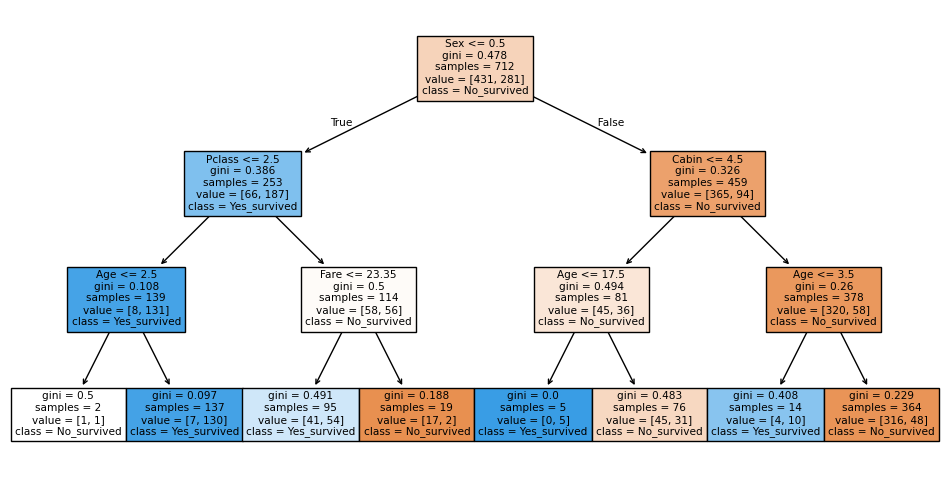

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(12, 6))
_ = plot_tree(model, class_names=['No_survived', 'Yes_survived'], feature_names=features, filled=True)

인덱스 130번 승객의 정보를 가지고 의사 결정 트리를 따라 예측해보면 이 승객은 사망(No_survived)

원래 데이터에서도 이 승객은 사망했다고 나와있으므로 예측 성공

In [ ]:
print("피처 중요도: \n{}".format(model.feature_importances_))

피처 중요도: 
[0.17006972 0.62106842 0.08822398 0.         0.         0.04529868
 0.0753392  0.        ]


<Axes: ylabel='Feature'>

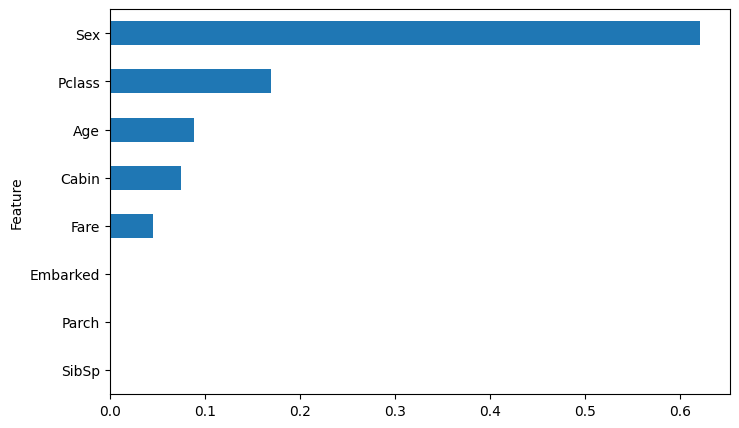

In [ ]:
# 피처 중요도 시각화
importances = pd.Series(model.feature_importances_, features)
plt.figure(figsize=(8, 5))
plt.xlabel("Feature importances")
plt.ylabel("Feature")
importances.sort_values().plot.barh()

성별, 객실등급, 나이 순으로 생존 여부에 영향을 끼친다.